# Imports and installs

In [ ]:
#pip install XGBoost

In [1]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap

/home/jonathan/.pyenv/versions/3.8.12/envs/OnThePitch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [2]:
# Customise based on your path and folder organisation
print(os.listdir('../raw_data/All4'))

['spain_2019_2020_1.csv', 'italy_2020_2021_2.csv', 'germany2_2019_2020.csv:Zone.Identifier', 'england3_2019_2020.csv:Zone.Identifier', 'england4_2020_2021.csv:Zone.Identifier', 'italy_2021_2022_1.csv', 'italy_2020_2021.csv:Zone.Identifier', 'italy_2021_2022_2.csv', 'spain_2020_2021_1.csv', 'scotland4_2021_2022.csv:Zone.Identifier', 'portugal_2020_2021.csv:Zone.Identifier', 'scotland_2021_2022.csv:Zone.Identifier', 'germany2_2020_2021.csv:Zone.Identifier', 'spain_2020_2021_2.csv', 'scotland_2020_2021_2.csv', 'Turkey_2021_2022_1.csv', 'france2_2021_2022.csv:Zone.Identifier', 'scotland_2020_2021_3.csv', 'scotland2_2020_2021.csv:Zone.Identifier', 'scotland_2019_2020_1.csv', 'england3_2021_2022.csv:Zone.Identifier', 'france_2019_2020.csv:Zone.Identifier', 'france_2021_2022_1.csv', 'england2_2020_2021.csv:Zone.Identifier', 'germany_2021_2022_1.csv', 'belgium_2020_2021_1.csv', 'scotland_2021_2022_4.csv', 'Eredivisie_2020_2021.csv:Zone.Identifier', 'Greece_2020_2021.csv:Zone.Identifier', 'scot

In [3]:
# Concatenate all the CSVs

files = [file for file in os.listdir('../raw_data/All4') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/All4/' + file)
    df['country']=str(file)[0:2]
    df['country_division']=str(file)[-5:-4]
    data = pd.concat([data, df])

# Features Engineering

In [4]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 99999]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    
    lst1 = []
    lst2 = []
    for i, team in enumerate(data['HomeTeam']):
        date = data['Date'].iloc[i]
        total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
        n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
        try:
            lst1.append(1/(n_under_home[1]/total))
            lst2.append(n_under_home[1]/total)
        except:
            lst1.append(np.nan)
            lst2.append(np.nan)

    data['odds_home_under'] = lst1
    data['prob_home_under'] = lst2
    
    #binning the probability of the home team to have a game of less than 2.5 score
    data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, bins)
    
    
    #----------------------- Odds and probability of the away team scoring under 2.5 -------------------------------
    
    lst3 = []
    lst4  = []
    for i, team in enumerate(data['AwayTeam']):
        date = data['Date'].iloc[i]
        total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
        n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
        try:
            lst3.append(1/(n_under_away2[1] / total2))
            lst4.append(n_under_away2[1] / total2)
        except:
            lst3.append(np.nan)
            lst4.append(np.nan)

    data['odds_away_under'] = lst3
    data['prob_away_under'] = lst4
    
    #binning the probability of the away team to have a game of less than 2.5 score
    data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, bins)

    #-------------------------- Creating the prob and odds of the game -----------------------------------------------
    '''the mean between the probability of the home team to have a score of under 2.5 and the probability 
    of the away team to do the same'''
    
    data['odds_game'] = (data['odds_away_under'] +  data['odds_home_under']) / 2
    data['prob_game'] = (data['prob_away_under'] + data['prob_home_under']) / 2
    
    #-------------------------- OneHotEncoding the binned probabilities columns ------------------------------------------
    

    if b == 5:
        data = data[~data['binned prob_home_under'].isna()]
        ohe = OneHotEncoder(sparse=False)
        ohe.fit(data[['binned prob_home_under']])
        bins_encoded = ohe.transform(data[['binned prob_home_under']])
        data["0, 20"], data["20, 40"], data["40, 60"], data["60, 80"], data["80, 100"] = bins_encoded.T
        
    if b == 10:
        data = data[~data['binned prob_home_under'].isna()]
        ohe = OneHotEncoder(sparse=False)
        ohe.fit(data[['binned prob_home_under']])
        bins_encoded = ohe.transform(data[['binned prob_home_under']])
        data["0, 10"], data["10, 20"], data["20, 30"], data["30, 40"], data["40, 50"], data["50, 60"], \
        data["60, 70"], data["70, 80"], data["80, 90"], data["90, 100"] = bins_encoded.T
        
    if b == 20:
        data = data[~data['binned prob_home_under'].isna()]
        ohe = OneHotEncoder(sparse=False)
        ohe.fit(data[['binned prob_home_under']])
        bins_encoded = ohe.transform(data[['binned prob_home_under']])
        data["0, 5"], data["5, 10"], data["10, 15"], data["15, 20"], data["20, 25"], data["25, 30"], \
        data["30, 35"], data["35, 40"], data["40, 45"], data["45, 50"], data["50, 55"], data["55, 60"], \
        data["60, 65"], data["65, 70"], data["70, 75"], data["75, 80"], data["80, 85"], data["85, 90"], \
        data["90, 95"], data["95, 100"]= bins_encoded.T
    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3.0"], data["3.0_to_99999.0"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    data.drop(columns='country_division', inplace=True)
    
    return data

In [6]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [12]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

# Running the XGB model for under 2.5

In [16]:
# Creating the model dataset with relevant variables
data_linear_booleans_lean_P_under = data[['country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','year_2021_2022','game_starts_after_4pm','Market_consensus','%vig_p_bool','1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0','payout_under_2.5_pinacle_closing']]

## Defining the function testing_models

In [17]:
# results_lr_true = []
# results_lr_false = []
results_xgb_true = [] 
results_xgb_false = [] 

def testing_models(iterations):   
    i=0
    while i < iterations:
        # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Run Linear Regression
#         results_linear_regression = sm.OLS(y_train,X_train.astype(float)).fit()
#         y_pred_lr = results_linear_regression.predict(X_test.astype(float))
#         #results.summary()

        #Initiate XGBoost
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train,y_train) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #Linear Regression
#         y_pred_lr_under_0_median = y_pred_lr[y_pred_lr<0].median()
#         y_pred_lr_under_0_min = y_pred_lr[y_pred_lr<0].min()
#         y_pred_lr_over_0_median = ifnull(y_pred_lr[y_pred_lr>0].median(),0.05)

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------
#         #Linear Regression
#         bins3_lr = [y_pred_lr_under_0_min-0.0000002, y_pred_lr_under_0_median-0.0000001, 0, y_pred_lr_over_0_median+0.0000001, 1]
#         y_lr_df = pd.DataFrame(y_test)
#         y_pred_lr_df = pd.DataFrame(y_pred_lr)
#         y_pred_lr_df["binned_pred"] = pd.cut(y_pred_lr_df[0], bins3_lr)
#         ind = np.arange(0, len(y_pred_lr_df))
#         ind = ind.tolist()
#         y_lr_df['ind'] = ind
#         y_pred_lr_df['ind'] = ind
#         y_final_lr = y_lr_df.merge(y_pred_lr_df, on="ind")#, on = "axis")#, how = "inner")
#         y_final_lr['bet_opp']=y_final_lr[0]>0

        #XGB
        #bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        #y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #Linear Regression
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])

#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         lr_results_False = y_final_lr[y_final_lr['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
#         lr_results_True = y_final_lr[y_final_lr['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()        
        

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        
        i=i+1

## Running the function testing_models 

In [18]:
# Select here the variables you want to include in the testing
X1 = data_linear_booleans_lean_P_under[['country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','year_2021_2022','game_starts_after_4pm','Market_consensus','%vig_p_bool','1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0']]
y = data_linear_booleans_lean_P_under['payout_under_2.5_pinacle_closing']-1

In [29]:
# Run the function testing_models
testing_models(100)

In [30]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_xgb_false))
median_results_good_bets = np.median(np.array(results_xgb_true))

In [31]:
# Delta variable (gap between bad and good group) is the variable we aim to maximise with our features and models fine-tuning, the greater the better!
delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))

In [32]:
print(delta)

0.02825954796140221


<AxesSubplot:ylabel='Count'>

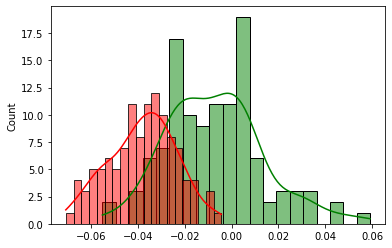

In [34]:
# Plotting the results of the XGB
sns.histplot(results_xgb_true,kde=True,bins=20,color='green')
sns.histplot(results_xgb_false,kde=True,bins=20,color='red')

# Comments regarding results of the tests we ran and Next Steps

In [ ]:
## Comments

# baseline = 0.008297694850435258 (all features)

# delta without Joao features = 0.014419296789770412 => F:-0.029970666611150436 and T:-0.015551369821380024
# --> WE REMOVE JOAO FEATURE

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the countries and divisions = 0.004795286566703704
# --> WE KEEP THE COUNTRIES AND DIVISIONS

# delta when removing the divisions but keeping the countries = 0.008380480363148559 (worsening)
# delta when removing the countries but keeping the divisions = 0.02259680830123266 (best score ever)
# --> WE KEEP THE DIVSIONS AND REMOVE THE COUNTRIES

# delta when removing the 'month_after_July': 0.013657154854343441 DECREASED A LOT! We keep month after July
# year 2020_2021 = 0.012829398919170131 DECREASED A LOT! 
# TIME MATTERS!! We need months, years, time

# New basline: 0.023917075840908224

#'Pin pays better' does not improve the baseline and we remove it

#'Market_consensus' MATTERS we keep it

#VIG matters

# We should remove the P<PC variable
# BEST DELTA: 0.03151890594630853


In [ ]:
# Next steps:

## Time: Further explore how to optimise the features of time (years, months, hours, etc.)
## Odds: Further explore how to optimise the odds buckets (different bins, min-max scaling)
## VIG + Mkt Consensus: Further explore how to optimise VIG + Market consensus

# [SKIP] Other models + stats package we could use [SKIP]

In [ ]:
# Random Forest

In [ ]:
my_model = RandomForestRegressor(random_state=0).fit(X_step_joao, y)

In [ ]:
y_pred = my_model.predict(X_step_joao)

In [ ]:
# SHAP values

In [ ]:
#import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_step_joao)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_step_joao)

#- Vertical location shows what feature it is depicting
#- Color shows whether that feature was high or low for that row of the dataset
#- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

In [ ]:
shap.summary_plot(shap_values, X_step_joao, plot_type="bar")